# 🚀 Lead Scoring Notebook

**Author:** Likhith Bhargav  
**Date:** 2025-06-13  
**Project:** Project Origins – B2B Lead Scoring  


# 1️⃣ Import Dependencies

We need the Snowflake connector, data libraries, modeling tools and PFI for explainability.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Snowflake connector
import snowflake.connector

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Explainability
from sklearn.inspection import permutation_importance

# 2️⃣ Connect to Snowflake

Define a helper to fetch tables into pandas.


In [2]:
# Snowflake credentials
conn = snowflake.connector.connect(
    user='LIKHITHBHARGAV',
    password='Likhithbhargav@704',
    account='WZVSKFD-DBC58115',        # e.g. xy12345.us-east-1
    warehouse='COMPUTE_WH',
    database='LEAD_SCORING',
    schema='PUBLIC'
)

def fetch(sql):
    """Helper: run a query and return a DataFrame."""
    cur = conn.cursor()
    cur.execute(sql)
    cols = [c[0] for c in cur.description]
    df = pd.DataFrame(cur.fetchall(), columns=cols)
    cur.close()
    return df

# 3️⃣ Load Data

Pull data from Snowflake.


In [3]:
leads = fetch("SELECT * FROM leads;")
companies = fetch("SELECT * FROM company_firmographics;")
eng = fetch("SELECT lead_id, action, timestamp FROM marketing_engagements;")

# Quick sanity‐check
print(leads.shape, companies.shape, eng.shape)

(2000, 7) (200, 7) (3003, 3)


# 4️⃣ Define Conversion Target

We’ll flag a lead as “CONVERTED” if they requested a demo or attended a webinar.


In [4]:
# 3) Building target using demo_request & Webinar_attendance as conversions
conversion_actions = ["demo_request", "webinar_attendance"]

conv = (
    eng[eng['ACTION'].isin(conversion_actions)]
      .groupby('LEAD_ID')
      .size()
      .reset_index(name='N_CONV')
)
conv['CONVERTED'] = 1

df = leads.merge(conv[['LEAD_ID','CONVERTED']], on='LEAD_ID', how='left')
df['CONVERTED'] = df['CONVERTED'].fillna(0).astype(int)

# 5️⃣ Feature Engineering

1. Merge firmographics  
2. Action-level counts  
3. Engagement summaries  
4. Refined recency (exclude conversion actions)  
5. Lead age  
6. One-hot encode industry  


In [5]:
# 1) Merge in firmographics
df = df.merge(
    companies[['COMPANY_ID','INDUSTRY','EMPLOYEE_COUNT','ANNUAL_REVENUE','HQ_LOCATION']],
    on='COMPANY_ID', how='left'
)

# 2) Pivot engagement counts per action
action_counts = (
    eng
    .groupby(['LEAD_ID','ACTION'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
# rename columns to count_<action>
action_counts = action_counts.rename(columns=lambda c: f"count_{c}" if c != 'LEAD_ID' else c)

df = df.merge(action_counts, on='LEAD_ID', how='left').fillna(0)

In [6]:
# 3) Total engagements & unique actions
df['total_engagements'] = (
    df[[c for c in df.columns if c.startswith('count_')]]
    .sum(axis=1)
)
# compute unique-action counts
unique_actions = (
    eng
    .groupby('LEAD_ID')['ACTION']
    .nunique()
    .reset_index(name='unique_actions')
)

# merge into df
df = df.merge(unique_actions, on='LEAD_ID', how='left')
df['unique_actions'] = df['unique_actions'].fillna(0).astype(int)

In [7]:
# 4) Recency: days since last engagement i.e. Timestamp (exclude conversion actions)

# Define non-conversion engagements
nonconv = eng[~eng['ACTION'].isin(conversion_actions)]

# Compute recency on that subset
last_non = (
    nonconv.groupby('LEAD_ID')['TIMESTAMP']
           .max()
           .reset_index(name='last_nonconv_ts')
)
last_non['days_since_nonconv'] = (
    pd.Timestamp.now() - last_non['last_nonconv_ts']
).dt.days

# Merge (and fill)
df = df.merge(
    last_non[['LEAD_ID','days_since_nonconv']],
    on='LEAD_ID',
    how='left'
).fillna({'days_since_nonconv': 999})

# 5) Lead age (days since creation)

# Convert CREATED_DATE into a pandas datetime dtype
df['CREATED_DATE'] = pd.to_datetime(df['CREATED_DATE'])

# Use pandas Timestamp.now() so both sides are Timestamps
now = pd.Timestamp.now()

df['lead_age'] = (now - df['CREATED_DATE']).dt.days

# 6) One-hot encode industry
df['RAW_INDUSTRY'] = df['INDUSTRY']

df = pd.get_dummies(df, columns=['INDUSTRY'], drop_first=False)

# 6️⃣ Define Feature Sets

We’ll compare three packs, then use the refined one.


In [8]:
# Firmographics + lead_age 
fg = ['EMPLOYEE_COUNT','ANNUAL_REVENUE','lead_age'] + [c for c in df if c.startswith('INDUSTRY_')]

# Add simple engagement summaries (Counts only)
eng1 = fg + ['total_engagements','unique_actions']

# Counts + Refined Recency
eng2 = eng1 + ['days_since_nonconv']

print("FG features:", fg)
print("Eng1 features:", eng1)
print("Eng3 features:", eng2)

FG features: ['EMPLOYEE_COUNT', 'ANNUAL_REVENUE', 'lead_age', 'INDUSTRY_Finance', 'INDUSTRY_Healthcare', 'INDUSTRY_Manufacturing', 'INDUSTRY_Retail', 'INDUSTRY_Technology']
Eng1 features: ['EMPLOYEE_COUNT', 'ANNUAL_REVENUE', 'lead_age', 'INDUSTRY_Finance', 'INDUSTRY_Healthcare', 'INDUSTRY_Manufacturing', 'INDUSTRY_Retail', 'INDUSTRY_Technology', 'total_engagements', 'unique_actions']
Eng3 features: ['EMPLOYEE_COUNT', 'ANNUAL_REVENUE', 'lead_age', 'INDUSTRY_Finance', 'INDUSTRY_Healthcare', 'INDUSTRY_Manufacturing', 'INDUSTRY_Retail', 'INDUSTRY_Technology', 'total_engagements', 'unique_actions', 'days_since_nonconv']


# 7️⃣ Model Training & Cross-Validation

Use stratified 5-fold CV to evaluate each feature pack.


In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',     # automatically handles imbalance
    random_state=42
)

for name, feats in [('Firmographics', fg),
                    ('+ Counts', eng1),
                    ('+ Counts+Recency', eng2)]:
    scores = cross_val_score(base_model, df[feats], df['CONVERTED'],
                             cv=cv, scoring='roc_auc')
    print(f"{name:25}: ROC AUC = {scores.mean():.3f} ± {scores.std():.3f}")

Firmographics            : ROC AUC = 0.927 ± 0.011
+ Counts                 : ROC AUC = 0.968 ± 0.015
+ Counts+Recency         : ROC AUC = 0.993 ± 0.004


# 8️⃣ Time-Based Hold-out Test

Validate on “future” leads (created ≥2025-05-15).


In [10]:
# split by creation date
cutoff = pd.to_datetime('2025-05-15')
train = df[df['CREATED_DATE'] < cutoff]
test  = df[df['CREATED_DATE'] >= cutoff]

X_tr, y_tr = train[eng2], train['CONVERTED']
X_te, y_te = test[eng2],  test['CONVERTED']

final_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_tr, y_tr)

print("Time-split ROC AUC:", 
      roc_auc_score(y_te, final_model.predict_proba(X_te)[:,1]).round(3))
print(classification_report(y_te, final_model.predict(X_te)))

Time-split ROC AUC: 0.947
              precision    recall  f1-score   support

           0       0.96      0.61      0.75        82
           1       0.88      0.99      0.93       230

    accuracy                           0.89       312
   macro avg       0.92      0.80      0.84       312
weighted avg       0.90      0.89      0.88       312



# 9️⃣ Hyperparameter Tuning

Grid search on the refined pack.


In [11]:
param_grid = {
    'n_estimators':    [100,200,300],
    'max_depth':       [None,5,10],
    'min_samples_leaf':[1,5,10]
}

grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(df[eng2], df['CONVERTED'])

print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_.round(3))
final_model = grid.best_estimator_

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
Best CV AUC: 0.994


# 🔄 Refit Final Model on Full Dataset

Having determined the best hyperparameters via cross‐validation, we now retrain the Random Forest on the entire dataset (`eng2` features + all rows) to prepare our final `lead_score` predictions.


In [12]:
# Best parameters from CV
best_params = {
    'n_estimators': 300,
    'max_depth': None,
    'min_samples_leaf': 1,
    'class_weight': 'balanced',
    'random_state': 42
}

final_model = RandomForestClassifier(**best_params)
final_model.fit(df[eng2], df['CONVERTED'])

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

# New File Processing
# Define Column & Stage Mappings


In [13]:
col_map = {
    'Deal Id': 'lead_id',
    'Created Time': 'created_date',
    'Last Activity Time': 'timestamp',
    'Company Name.id' : 'company_id'
}

# Map raw Stage values → our engagement “action” labels
stage_to_action = {
    'Std Free Trial': 'demo_request',
    'Entered 7 Day Free Trial': 'demo_request',
    'Pitch & Demo': 'webinar_attendance',
}

# Load & Rename the New CSV


In [14]:
raw_new = pd.read_csv(
    './Data/Pipelines_2025_06_11.csv',
    parse_dates=['Created Time','Last Activity Time']  # ensure these match your raw file
)
raw_new = raw_new.rename(columns=col_map)

# Flag Every Engagement & Mark Conversions


In [15]:
# Keep every raw Stage as an engagement action
raw_new['action'] = raw_new['Stage']

# Build a binary "converted" flag
conversion_stages = list(stage_to_action.keys())
raw_new['converted'] = raw_new['Stage'].isin(conversion_stages).astype(int)

# Normalize & Merge Firmographics

In [16]:
# Standardize company DataFrame to lowercase column names
companies = companies.rename(columns={
    'COMPANY_ID':      'company_id',
    'COMPANY_NAME':    'company_name',
    'INDUSTRY':        'industry',
    'EMPLOYEE_COUNT':  'employee_count',
    'ANNUAL_REVENUE':  'annual_revenue',
    'TECH_STACK':      'tech_stack',
    'HQ_LOCATION':     'hq_location'
})

# Merge in company‐level data
raw_new = raw_new.merge(
    companies[['company_name','company_id','industry','employee_count','annual_revenue']],
    left_on='Company Name',
    right_on='company_name',
    how='left'
)
raw_new['industry'] = raw_new['industry'].fillna('Unknown')  # catch any misses

# Compute Core Features: Lead Age, Engagement Metrics & Recency

In [17]:
# — Lead age —
raw_new['lead_age'] = (pd.Timestamp.now() - raw_new['created_date']).dt.days

# — Engagement counts & unique actions —
eng_new = raw_new[['lead_id','action','timestamp']]
agg = eng_new.groupby('lead_id').agg(
    total_engagements=('action','count'),
    unique_actions   =('action','nunique')
).reset_index()
raw_new = raw_new.merge(agg, on='lead_id', how='left').fillna({'total_engagements':0,'unique_actions':0})

# — Refined recency (exclude conversion actions) —
nonconv_new = eng_new[~eng_new['action'].isin(conversion_stages)]
last_non = (nonconv_new.groupby('lead_id')['timestamp']
                     .max()
                     .reset_index(name='last_nonconv_ts'))
last_non['days_since_nonconv'] = (pd.Timestamp.now() - last_non['last_nonconv_ts']).dt.days
raw_new = raw_new.merge(last_non[['lead_id','days_since_nonconv']], on='lead_id', how='left')
raw_new['days_since_nonconv'] = raw_new['days_since_nonconv'].fillna(999).astype(int)

# One-Hot Encode Industry & Build Model Input

In [18]:
# — One-hot encode industry —
raw_new['industry_raw'] = raw_new['industry']
raw_new = pd.get_dummies(raw_new, columns=['industry'], drop_first=False)

# Collect feature columns
dummy_cols = [c for c in raw_new.columns if c.startswith('industry_')]
feature_cols_new = [
    'employee_count','annual_revenue','lead_age',
    'total_engagements','unique_actions','days_since_nonconv'
] + dummy_cols

# Build the DataFrame your model expects
model_input_new = (
    raw_new
    .drop_duplicates('lead_id')
    .set_index('lead_id')[feature_cols_new]
)

# Align Columns, Score with Final Model & Export


In [19]:
# 1) Dropping vestigial columns the model never saw
model_input_new = model_input_new.drop(columns=['industry_raw','INDUSTRY_Unknown'], errors='ignore')

# 2) Renaming lower-case columns to the exact uppercase names
model_input_new = model_input_new.rename(columns={
    'LEAD_AGE': 'lead_age', 
    'TOTAL_ENGAGEMENTS': 'total_engagements', 
    'UNIQUE_ACTIONS': 'unique_actions', 
    'DAYS_SINCE_NONCONV': 'days_since_nonconv',
    'employee_count':     'EMPLOYEE_COUNT',
    'annual_revenue':     'ANNUAL_REVENUE',
})

# 3) Ensure every dummy the model expects exists (zero-fill if missing)
for feat in final_model.feature_names_in_:
    if feat.startswith('INDUSTRY_') and feat not in model_input_new.columns:
        model_input_new[feat] = 0

# 4) Reorder columns to exactly the model’s feature list
model_input_new = model_input_new[final_model.feature_names_in_]

# 5) Predict probabilities
model_input_new['lead_score'] = final_model.predict_proba(model_input_new)[:,1]

scored = model_input_new[['lead_score']].copy()
anc = (
    raw_new
      .drop_duplicates('lead_id')
      .set_index('lead_id')[
          ['Company Name','Contact Name','lead_age','days_since_nonconv']
      ]
)
output = scored.join(anc, how='left').reset_index()   
output = output[
    ['lead_id','Company Name','Contact Name','lead_age','days_since_nonconv','lead_score']
]

#6 Write to csv
output.to_csv('./Data/enriched_lead_scores.csv', index=False)

# 🔟 Extract & Save Lead Scores

Prepare a CSV for Power BI ingestion.


In [ ]:
# Compute probability of conversion
df['lead_score'] = final_model.predict_proba(df[eng2])[:, 1]

# Prepare output table for BI
output = df[[
    'LEAD_ID',
    'RAW_INDUSTRY',         # original industry label
    'EMPLOYEE_COUNT',
    'ANNUAL_REVENUE',
    'CREATED_DATE',
    'total_engagements',
    'unique_actions',
    'days_since_nonconv',
    'lead_score',
    'lead_age'
]]

# Save to CSV
output.to_csv('./Data/lead_scores.csv', index=False)

# 1️⃣1️⃣ Global Interpretability: Permutation Feature Importance

We’ll use scikit-learn’s **permutation_importance** to measure how much each feature, when shuffled, decreases our model’s ROC AUC on the held-out “future” set.  Features whose shuffling causes the largest drop are most important.


Permutation Feature Importances (mean ΔAUC):
unique_actions            0.1490
days_since_nonconv        0.1169
total_engagements         0.0040
ANNUAL_REVENUE            0.0013
EMPLOYEE_COUNT            0.0006
lead_age                  0.0000
INDUSTRY_Finance          0.0000
INDUSTRY_Healthcare       0.0000
INDUSTRY_Retail           0.0000
INDUSTRY_Technology       0.0000
INDUSTRY_Manufacturing    0.0000
dtype: float64


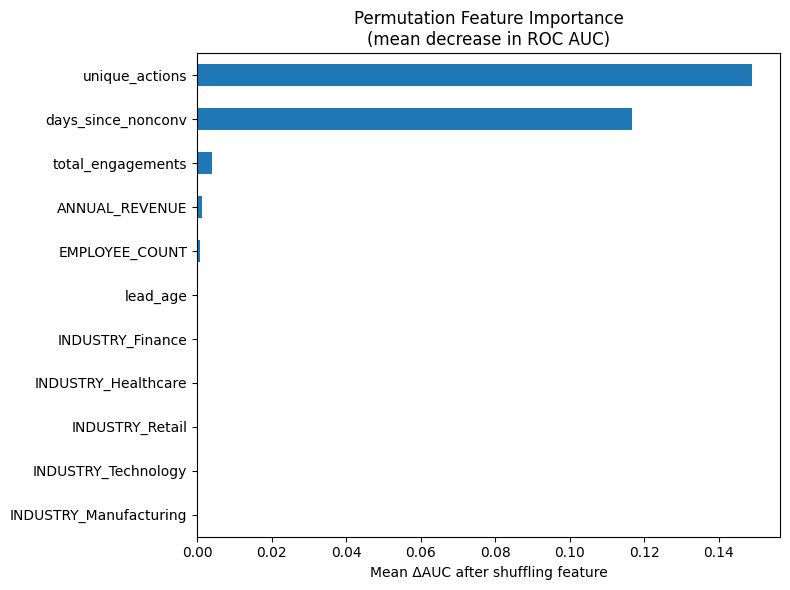

In [20]:
test = df[df['CREATED_DATE'] >= cutoff]
X_te = test[eng2]
y_te = test['CONVERTED']

# — Compute permutation importances over 10 repeats —
perm_res = permutation_importance(
    final_model,
    X_te,
    y_te,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

# — Aggregate into a pandas Series and sort descending —
perm_importances = pd.Series(
    perm_res.importances_mean,
    index=eng2
).sort_values(ascending=False)

# — Display the importances —
print("Permutation Feature Importances (mean ΔAUC):")
print(perm_importances.round(4))

# — Plot a horizontal bar chart —
perm_importances.plot.barh(figsize=(8, 6))
plt.title("Permutation Feature Importance\n(mean decrease in ROC AUC)")
plt.xlabel("Mean ΔAUC after shuffling feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
